In [242]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import zipfile
import numpy as np

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier
from scipy.signal import periodogram

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from prophet import Prophet
from tqdm import tqdm

from warnings import simplefilter
simplefilter('ignore')
plt.style.use("ggplot")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color = '0.75',
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)


## Data Preprocessing

In [3]:
cwd = Path.cwd() 
comp_dir = cwd / 'Kaggle_data' / 'store-sales-time-series-forecasting'
with zipfile.ZipFile(comp_dir / 'train.csv.zip', 'r') as rip_ref:
    rip_ref.extract('train.csv', path = 'temporary_folder')
train_file_path = Path('temporary_folder', 'train.csv')

Тренировочные данные. С 2013 по 2017 год

In [4]:
store_sales_train = pd.read_csv(
    train_file_path,
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32'},
    parse_dates=['date'],
    infer_datetime_format=True)

store_sales_train['date'] = store_sales_train.date.dt.to_period('D')
store_sales_train['item'] = "S" + store_sales_train['store_nbr'].astype(str) + "_" + store_sales_train['family'].astype(str)
df = store_sales_train.pivot(index='date', columns='item', values='sales')
store_sales_train = store_sales_train.set_index(['date']).sort_index()

Тестовые данные

In [154]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

df_test_temp = df_test
df_test['date'] = df_test.date.dt.to_period('D')

df_test['item'] = "S" + df_test['store_nbr'].astype(str) + "_" + df_test['family'].astype(str)
df_test = df_test.set_index(['date']).sort_index()

In [155]:
df_test.head(5)

,id,store_nbr,family,onpromotion,item
date,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,S1_AUTOMOTIVE
2017-08-16,3000889,1,BABY CARE,0,S1_BABY CARE
2017-08-16,3000890,1,BEAUTY,2,S1_BEAUTY
2017-08-16,3000891,1,BEVERAGES,20,S1_BEVERAGES
2017-08-16,3000892,1,BOOKS,0,S1_BOOKS


Праздники. Отбираем только национальные и региональные

In [8]:
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

holidays_events = holidays_events.set_index('date').to_period('D')
holidays = (
  holidays_events.query('locale in ["National", "Regional"]').loc['2017':'2017-08-15', ['description']]
  .assign(description = lambda x: x.description.cat.remove_unused_categories()))
    
holidays = pd.get_dummies(holidays, dtype=float)

In [9]:
holidays.head(5)

,description_Batalla de Pichincha,description_Carnaval,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-02-27,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Ежедневная цена на нефть

In [10]:
oil_df = pd.read_csv(
    comp_dir / 'oil.csv',
    parse_dates=['date'],
    infer_datetime_format=True)
oil_df = oil_df.set_index('date').to_period('D')

Кол-во транзакций в магазинах по дням

df_test

2017-08-16 : 2017-08-31	

df_train

2017-01-01 : 2017-08-15

Прогнозируем цены на конец Агуста 2017 года. Обучаемся на  всем 2017г

In [136]:
def get_X1_data_FourierFunction(y):
    fourier = CalendarFourier(freq='M', order=4)         
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True,
    )
    X_1 = dp.in_sample()
    X_1['NewYear'] = (X_1.index.dayofyear == 1)
    return X_1

In [137]:
def get_X2_data(store_sales_train, holidays, start_global, end_global, add_feature_dict): #Make lags + oil_price??? + (transaction???) + rollin mean

    
    X_2 = store_sales_train.drop(['sales', 'store_nbr', 'item'], axis=1).loc[start_global:end_global]
    le = LabelEncoder().fit(X_2.family)
    X_2['family'] = le.transform(X_2['family'])
    X_2['day'] = X_2.index.day

    if 'holidays' in add_feature_dict:    
        # holidays_train, holidays_test = add_feature_dict['holidays'][:start_global], add_feature_dict['holidays'][start_global:end_global]
        X_2 = X_2.join(holidays, on = 'date').fillna(0.0)
    if 'oil' in add_feature_dict:
        # oil_train, oil_test = add_feature_dict['oil'][:start_global], add_feature_dict['oil'][start_global:end_global]
        X_2 = X_2.join(add_feature_dict['oil'], on ='date').fillna(0.0)
    return X_2
    

In [134]:
def get_train_validation_data(time_periods, add_feature_dict):
    start_global, end_global, end_train_period, start_valid_period = time_periods
    y = df.loc[start_global:end_global]
    
    X_1 = get_X1_data_FourierFunction(y)
    # print(X_1.head(5))

    X_2 = get_X2_data(store_sales_train, holidays, start_global, end_global, add_feature_dict)
    # print(X_2.shape)  
    y_train, y_valid = y[:end_train_period], y[start_valid_period:]
    X1_train, X1_valid = X_1[: end_train_period], X_1[start_valid_period:]
    X2_train, X2_valid = X_2.loc[:end_train_period], X_2.loc[start_valid_period:]
    
    return y_train, y_valid, X1_train, X1_valid, X2_train, X2_valid

In [15]:
def get_forecast_sales_plot(store_nbr, family, y_fit, y_train, y_pred, y_valid):
    column = f'S{store_nbr}_{family}'
    
    MSLE_train = mean_squared_log_error(y_train[column], y_fit[column])
    MSLE_test = mean_squared_log_error(y_valid[column], y_pred[column])
    
    MAE_train = mean_absolute_error(y_train[column], y_fit[column])
    MAE_test = mean_absolute_error(y_valid[column], y_pred[column])
    fig, axs = plt.subplots(2,1, figsize = (15, 8))
    axs[1] = y_train[column].plot(**plot_params, label = 'Original time series', 
                                  title = f'Train: MAE = {MAE_train:.2f}   MSLE = {MSLE_train:.2f}\nTest: MAE = {MAE_test:.2f}   MSLE = {MSLE_test:.2f}')
    axs[1] = y_fit[column].plot(label = 'y_fit')
    axs[1] = y_valid[column].plot(**plot_params, label = 'y_valid')
    axs[1] = y_pred[column].plot(label = 'y_prediction', color = 'darkblue')
    axs[1].legend()

    axs[0] = y_valid[column].plot(**plot_params, ax = axs[0], label = 'y_valid', title =  f'Store number {store_nbr} - {family}')
    axs[0] = y_pred[column].plot(ax = axs[0], label = 'y_prediction', color = 'darkblue')
    axs[0].legend()

In [246]:
family_set = list(store_sales_train['family'].unique())
for i in range(0, len(family_set), 5):
    print(family_set[i:i+5], '\n')
print(len(family_set))

['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS'] 

['BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI'] 

['EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE'] 

['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR'] 

['LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS'] 

['PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS'] 

['PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'] 

33


## Тестрование моделей

### LinearRegression

In [257]:
start_global = '2017-01-01'
end_global = '2017-08-15'
end_train_period = "2017-07-01"
start_valid_period = "2017-07-02"

time_periods = (start_global, end_global, end_train_period, start_valid_period)

In [258]:
add_feature_dict = {
    'holidays': holidays,
    'oil': oil_df}

In [263]:
y_train

item,S10_AUTOMOTIVE,S10_BABY CARE,S10_BEAUTY,S10_BEVERAGES,S10_BOOKS,S10_BREAD/BAKERY,S10_CELEBRATION,S10_CLEANING,S10_DAIRY,S10_DELI,...,S9_MAGAZINES,S9_MEATS,S9_PERSONAL CARE,S9_PET SUPPLIES,S9_PLAYERS AND ELECTRONICS,S9_POULTRY,S9_PREPARED FOODS,S9_PRODUCE,S9_SCHOOL AND OFFICE SUPPLIES,S9_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2017-01-02,4.0,0.0,2.0,2025.0,0.0,174.0,5.0,1291.0,616.0,512.0,...,5.0,659.570007,1243.0,11.0,41.0,843.596008,115.188995,3136.895996,1.0,23.000000
2017-01-03,3.0,0.0,0.0,1652.0,0.0,180.0,3.0,1169.0,607.0,450.0,...,2.0,547.364014,876.0,6.0,15.0,714.659973,133.039001,3229.558105,1.0,14.000000
2017-01-04,6.0,0.0,1.0,1255.0,0.0,119.0,1.0,864.0,350.0,247.0,...,3.0,395.287994,677.0,6.0,13.0,536.830017,75.201004,1491.416992,7.0,0.000000
2017-01-05,2.0,0.0,3.0,1127.0,0.0,83.0,2.0,884.0,245.0,206.0,...,2.0,470.768005,604.0,7.0,10.0,414.100006,113.698997,1566.821045,1.0,17.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-27,0.0,0.0,6.0,897.0,0.0,97.0,4.0,584.0,323.0,265.0,...,4.0,283.641998,304.0,8.0,4.0,341.027008,133.522995,2093.763916,1.0,10.662000
2017-06-28,2.0,0.0,2.0,1040.0,0.0,64.0,6.0,509.0,449.0,241.0,...,2.0,263.454010,333.0,5.0,6.0,297.789001,105.939003,1215.280029,2.0,11.879000
2017-06-29,2.0,0.0,1.0,672.0,0.0,78.0,1.0,370.0,208.0,178.0,...,2.0,532.228027,273.0,8.0,8.0,285.334991,106.324997,1084.578979,2.0,10.250999


In [259]:
y_train, y_valid, X1_train, X1_valid, X2_train, X2_valid = get_train_validation_data(time_periods, add_feature_dict)
model1 = LinearRegression(fit_intercept =False)
history = model1.fit(X1_train, y_train)

y1_fit = pd.DataFrame(model1.predict(X1_train), index = X1_train.index, columns = y_train.columns)
y1_pred = pd.DataFrame(model1.predict(X1_valid), index = X1_valid.index, columns = y_valid.columns)
y1_fit = y1_fit[y1_fit > 0].fillna(0.0)
y1_pred = y1_pred[y1_pred > 0].fillna(0.0)

### 

RMSLE: 0.5683
RMSE: 260.5272


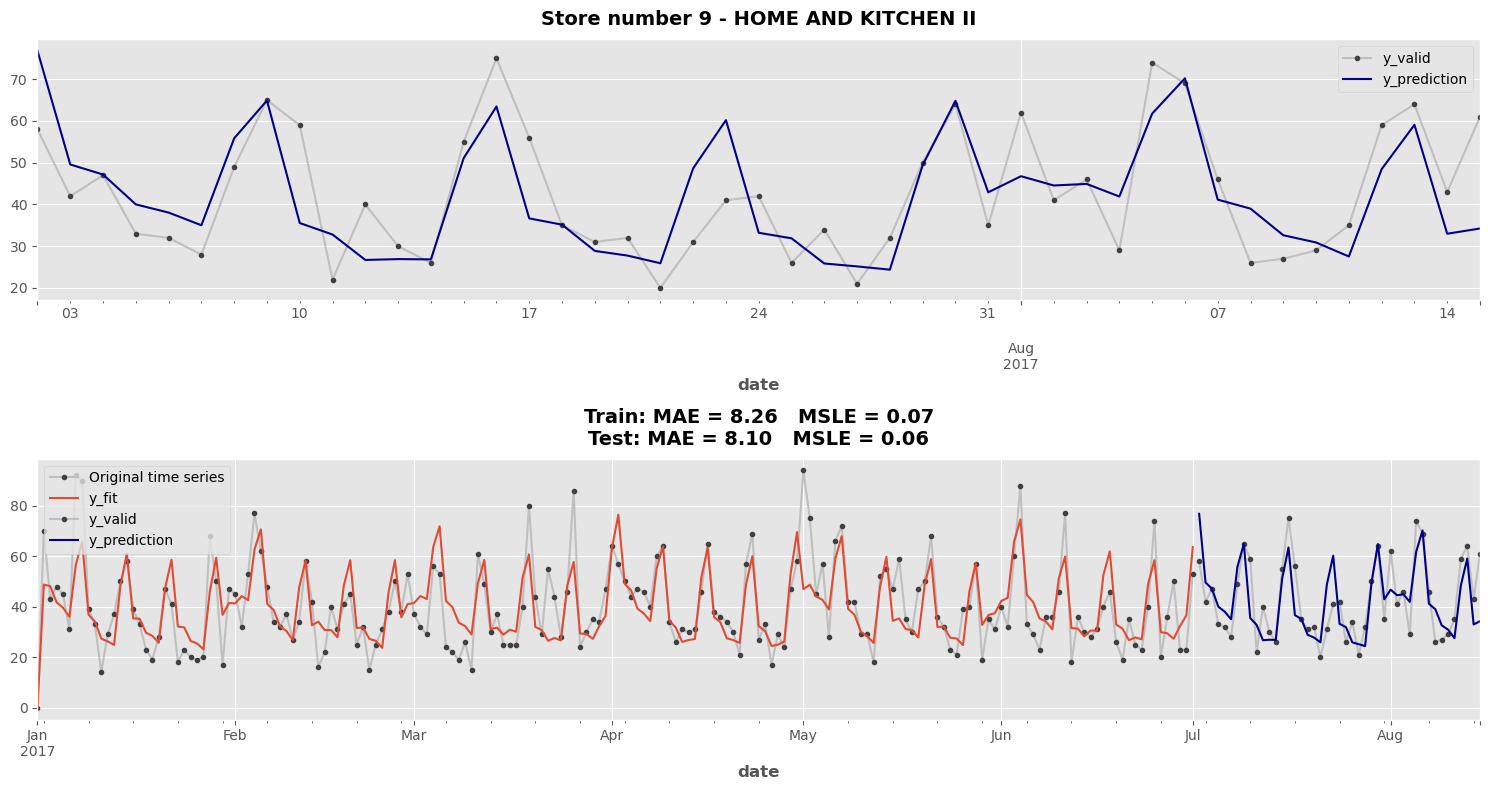

In [253]:
print(f'RMSLE: {np.sqrt(mean_squared_log_error(y_valid, y1_pred)):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_valid, y1_pred)):.4f}')
get_forecast_sales_plot('9','HOME AND KITCHEN II', y1_fit, y_train, y1_pred, y_valid)

[0]	train-rmse:239.36643	validation-rmse:260.49385
[100]	train-rmse:207.62319	validation-rmse:273.92940
[105]	train-rmse:207.24358	validation-rmse:274.06667
RMSLE: 0.8723
RMSE: 275.0867


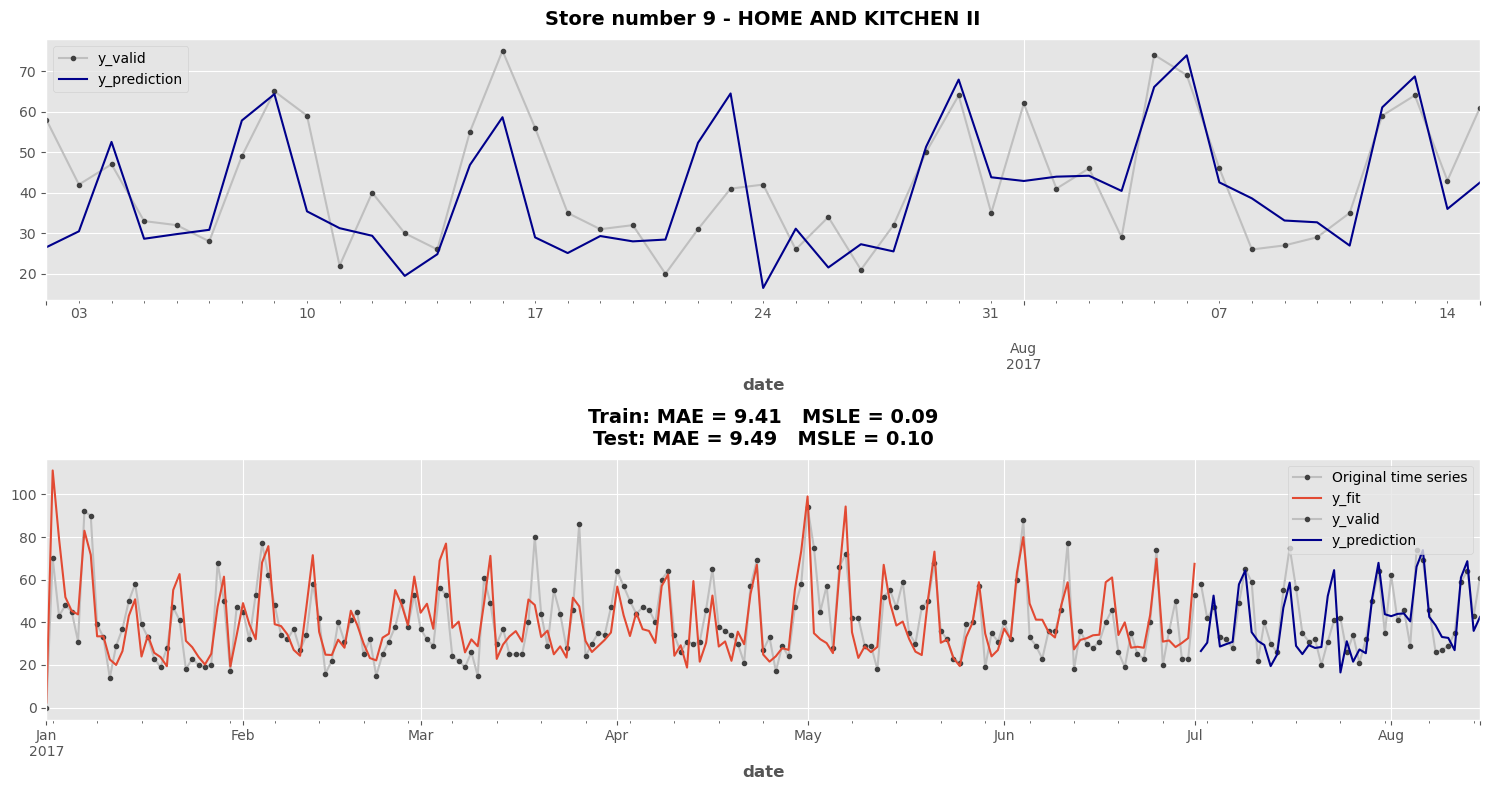

In [254]:
y_resid_train = (y_train - y1_fit)
y_resid_valid = (y_valid - y1_pred)

# X2_train = X2_train.astype('float32')
# X2_valid = X2_valid.astype('float32')

# X2_train = X2_train.join(y_resid_train.shift(1), on = 'date').fillna(0.0)
# X2_valid = X2_valid.join(y_resid_train.shift(1), on = 'date').fillna(0.0)

y_resid_train = y_resid_train.stack().squeeze()
y_resid_valid = y_resid_valid.stack().squeeze()

# model2 = XGBRegressor()
# model2.fit(X2_train, y_train)
# y2_fit_resid = pd.Series(model2.predict(X2_train), index = y_resid_train.index).unstack()
# y2_fit = (y2_fit_resid + y1_fit).clip(0.0)

# y2_pred_resid = pd.Series(model2.predict(X2_valid), index = y_resid_valid.index).unstack()
# y2_pred = (y2_pred_resid + y1_pred).clip(0.0)
params = {"objective": "reg:squarederror"}

xgb_train_df = xgb.DMatrix(X2_train, y_resid_train, enable_categorical=True)
xgb_valid_df = xgb.DMatrix(X2_valid, y_resid_valid, enable_categorical=True) 
evals = [(xgb_train_df, "train"), (xgb_valid_df, "validation")]
n = 5000

model2 = xgb.train(
   params=params,
   dtrain=xgb_train_df,
   num_boost_round=n,
   evals=evals,
   verbose_eval=100,
   early_stopping_rounds=100
)
y2_fit_resid = pd.Series(model2.predict(xgb_train_df), index = y_resid_train.index).unstack()
y2_fit = (y2_fit_resid + y1_fit).clip(0.0)
 
y2_pred_resid = pd.Series(model2.predict(xgb_valid_df), index = y_resid_valid.index).unstack()
y2_pred = (y2_pred_resid + y1_pred).clip(0.0)

print(f'RMSLE: {np.sqrt(mean_squared_log_error(y_valid, y2_pred)):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_valid, y2_pred)):.4f}')
get_forecast_sales_plot('9','HOME AND KITCHEN II', y2_fit, y_train, y2_pred, y_valid)

### Hybrid model

In [141]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        
def fit(self, X_1, X_2, y):
    
    self.model_1.fit(X_1, y)
    y_fit = pd.DataFrame(self.model_1.predict(X_1), index = X_1.index, columns = y.columns)
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze()

    self.model_2.fit(X_2, y_resid)

    self.y_columns = y.columns
    self.y_fit = y_fit
    self.y_resid = y_resid

def predict(self, X_1, X_2):
    
    y_pred = pd.DataFrame(self.model_1.predict(X_1), index=X_1.index, columns=self.y_columns)
    y_pred = y_pred.stack().squeeze()

    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()
    
BoostedHybrid.fit = fit
BoostedHybrid.predict = predict

### LinearRegression (l1 regularization) + XGBRegressor

In [255]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

RMSLE: 0.8777
RMSE: 275.0021


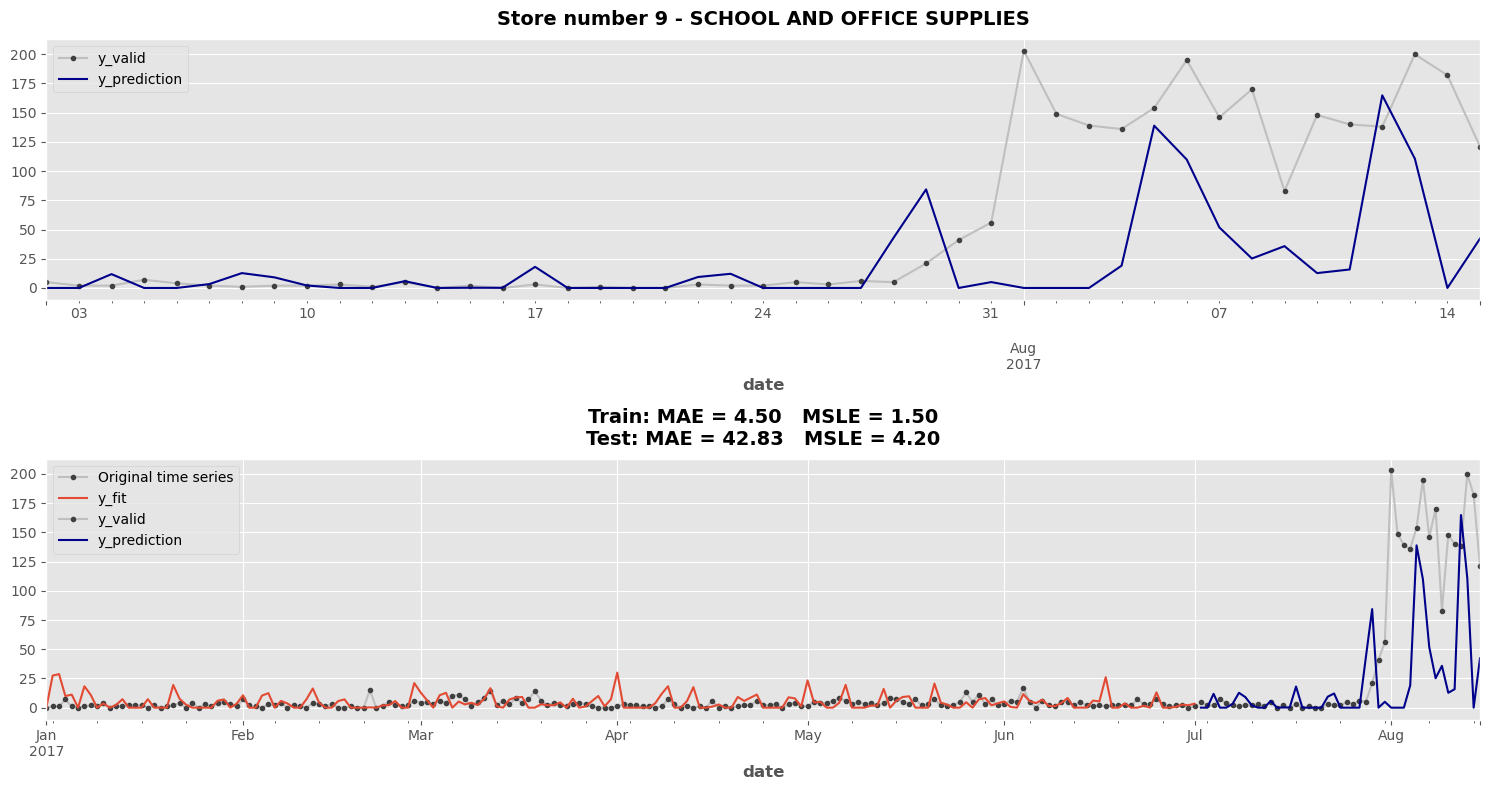

In [256]:
y_train, y_valid, X1_train, X1_valid, X2_train, X2_valid = get_train_validation_data(time_periods, add_feature_dict)

model = BoostedHybrid(
    model_1 = Lasso(),
    model_2 = XGBRegressor()
)
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

print(f'RMSLE: {np.sqrt(mean_squared_log_error(y_valid, y_pred)):.4f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_valid, y_pred)):.4f}')
get_forecast_sales_plot('9','SCHOOL AND OFFICE SUPPLIES', y_fit, y_train, y_pred, y_valid)

In [177]:
fourier = CalendarFourier(freq='M', order=4)         
dp = DeterministicProcess(
    index=df[:end_global].index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True)
X1_test = dp.out_of_sample(16)
X1_test['NewYear'] = (X_test.index.dayofyear == 1)

In [178]:
X2_test = df_test.drop(['id', 'store_nbr', 'item'], axis=1)
le = LabelEncoder().fit(X2_test.family)
X2_test['family'] = le.transform(X2_test['family'])
X2_test['day'] = X2_test.index.day
X2_test

,family,onpromotion,day
date,,,
2017-08-16,0,0,16
2017-08-16,1,0,16
2017-08-16,2,2,16
2017-08-16,3,20,16
2017-08-16,4,0,16
...,...,...,...
2017-08-31,28,1,31
2017-08-31,29,0,31
2017-08-31,30,1,31


In [179]:
X2_test = X2_test.join(holidays, on = 'date').fillna(0.0)
X2_test = X2_test.join(add_feature_dict['oil'], on ='date').fillna(0.0)

In [234]:
submit = pd.DataFrame(model.predict(X1_test, X2_test))
submit = submit.stack(['item'])
submit = submit.reset_index()
submit = submit.rename(columns = {0: 'sales', 'level_0': 'date'})
submit.set_index('date')
submit = pd.merge(submit, df_test, how='inner', on=['date','item'])
submit.drop(['date', 'item', 'store_nbr', 'family', 'onpromotion'], axis=1, inplace=True)

In [241]:
submit.to_csv('Store_sales_submission_.csv', index = False)

# Подход 2. Прогнозирую каждый ряд по отдельности

In [237]:
df_train = pd.read_csv(
    train_file_path,
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32'},
    parse_dates=['date'],
    infer_datetime_format=True)
df_train['date'] = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

In [238]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [239]:
df_test_ = df_test.drop('id', axis =1 )

In [240]:
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

holidays_events = holidays_events.set_index('date').to_period('D')
holidays = (
  holidays_events.query('locale in ["National", "Regional"]').loc[start_global:'2017-08-15', ['description']]
  .assign(description = lambda x: x.description.cat.remove_unused_categories()))
    
holidays = pd.get_dummies(holidays, dtype=float)

In [42]:
oil_df = pd.read_csv(
    comp_dir / 'oil.csv',
    parse_dates=['date'],
    infer_datetime_format=True)
oil_df = oil_df.set_index('date').to_period('D')

In [43]:
def make_lags(ts, lags):
    return pd.concat(
        {f'y_lag_{i}': ts.shift(i) for i in range(1, lags + 1)}, axis = 1)

In [64]:
def get_time_series(store_nbr, family_, y, time_periods, X_test = None, add_feature = True):
    start_global, end_global, end_train_period, start_valid_period = time_periods
    y_ = y.loc[store_nbr, family_][start_global:end_global]
    if add_feature != False:
        X_ = pd.DataFrame(index = y_.index)
        for feature in y_.columns:
            if feature != 'sales': X_[feature] = y_[feature]
        y_ = y_[['sales']]
    else:
        X_ = pd.DataFrame(index = y_.index)
        y_ = y_[['sales']]
    y_train, y_valid = y_[:end_train_period], y_[start_valid_period:]
    X_train, X_valid = X_[:end_train_period], X_[start_valid_period:]
    if type(X_test) == type(None):
        return X_train, X_valid, y_train, y_valid
    else:
        X_test = X_test.loc[store_nbr, family_]
        return X_train, X_valid, y_train, y_valid, X_test

In [63]:
def prepare_data_for_Prophet(X, y, X_test = None):
    
    X_res = X
    X_res = X_res.join(y, on = 'date').fillna(0.0)
    X_res.index = X_res.index.to_timestamp()
    X_res = X_res.reset_index()
    
    X_res = X_res.rename(columns = {'date': 'ds', 'sales': 'y'})
    add_features = np.array(X_res.columns)[np.isin(X_res.columns,['ds', 'y'], invert = True)]
    if type(X_test) == type(None):
        return X_res, add_features, X_test
    else:
        # X_test['y_lag_1'] = 1
        # X_test['y_lag_2'] = 1
        
        X_test.index = X_test.index.to_timestamp()
        X_test = X_test.reset_index()
        X_test = X_test.rename(columns = {'date': 'ds'})
        return X_res, add_features, X_test

In [264]:
def Prophet_fit_predict(add_features, df_fit, df_valid, df_test = None, forecast_params_flag = False):
    
    model = Prophet(changepoint_prior_scale=0.05,
                    seasonality_prior_scale=15.0,
                    seasonality_mode='multiplicative')
    
    for feature in add_features:
        model.add_regressor(feature)
        
    
    if type(df_test) == type(None):
        model.fit(df_fit)
        forecast_fit = model.predict(df_fit)
        
        model.plot_components(forecast_fit) 
        
        forecast_valid = model.predict(df_valid)
        # model.plot_components(forecast_valid) 

        if not forecast_params_flag:
            y_fit_forecast = forecast_fit['yhat']
            y_valid_forecast = forecast_valid['yhat']
            return y_fit_forecast, y_valid_forecast 
        else: pass
    else:
        all_data = pd.concat([df_fit, df_valid])
        model.fit(all_data)
        
        test_forecast = model.predict(df_test)
        test_forecast= test_forecast['yhat']

        return test_forecast
                  
        
        test_forecast = test_forecast['yhat']
        return test_forecast
        

In [96]:
def prophet_forecast_series(X_train, X_valid, y_train, y_valid, add_feature = None, X_test = None):
    if add_feature != None:
        for feature in add_feature:
            X_train_ = X_train.join(add_feature[feature], on = 'date').fillna(0.0)
            X_valid_ = X_valid.join(add_feature[feature], on = 'date').fillna(0.0)
            if type(X_test) != type(None): X_test = X_test.join(add_feature[feature], on = 'date').fillna(0.0)
    else:
        X_train_ = X_train.fillna(0.0)
        X_valid_ = X_valid.fillna(0.0)
        if type(X_test) != type(None): X_test = X_test.fillna(0.0)
        
    prophet_train_df, add_features, prophet_test_df = prepare_data_for_Prophet(X_train_, y_train, X_test) 
    prophet_valid_df, _, _ = prepare_data_for_Prophet(X_valid_, y_valid, None)

    
    if type(prophet_test_df) == type(None):
        y_fit_forecast, y_valid_forecast = Prophet_fit_predict(add_features, prophet_train_df, prophet_valid_df, prophet_test_df)
        y_fit_forecast.index = y_train.index
        y_valid_forecast.index = y_valid.index
        return y_fit_forecast.clip(0.0), y_valid_forecast.clip(0.0)
    else:
        test_forecast = Prophet_fit_predict(add_features, prophet_train_df, prophet_valid_df, prophet_test_df)
        test_forecast.index = X_test.index
        return test_forecast
    
   
    

In [97]:
def plot_timeseries(store_nbr, family, y_train, y_fit, y_valid, y_pred): 
    MAE_train = mean_absolute_error(y_train, y_fit)
    MAE_test = mean_absolute_error(y_valid, y_pred)
    
    MSE_train = mean_squared_error(y_train, y_fit)
    MSE_test = mean_squared_error(y_valid, y_pred)
    
    fig, axs = plt.subplots(2,1, figsize = (15, 8))
    y_train.plot(ax = axs[1], **plot_params, label = 'Original time series', 
                                  title = f'Train: MAE = {MAE_train:.2f}   MSE = {MSE_train:.2f}\nTest: MAE = {MAE_test:.2f}   MSE = {MSE_test:.2f}')
    y_fit.plot(ax = axs[1], label = 'y_fit')
    y_valid.plot(ax = axs[1], label = 'y_valid')
    y_pred.plot(ax = axs[1], label = 'y_prediction', color = 'darkblue')
    axs[1].legend()

    y_valid.plot(ax = axs[0], **plot_params, label = 'y_valid', title =  f'Store number {store_nbr} - {family}')
    y_pred.plot(ax = axs[0], label = 'y_prediction', color = 'darkblue')
    axs[0].legend()

In [265]:
start_global = '2017-01-01'
end_global = '2017-08-15'
end_train_period = "2017-07-01"
start_valid_period = "2017-07-02"

time_periods = (start_global, end_global, end_train_period, start_valid_period)
add_features = {'oil': oil_df, 'holidays': holidays}

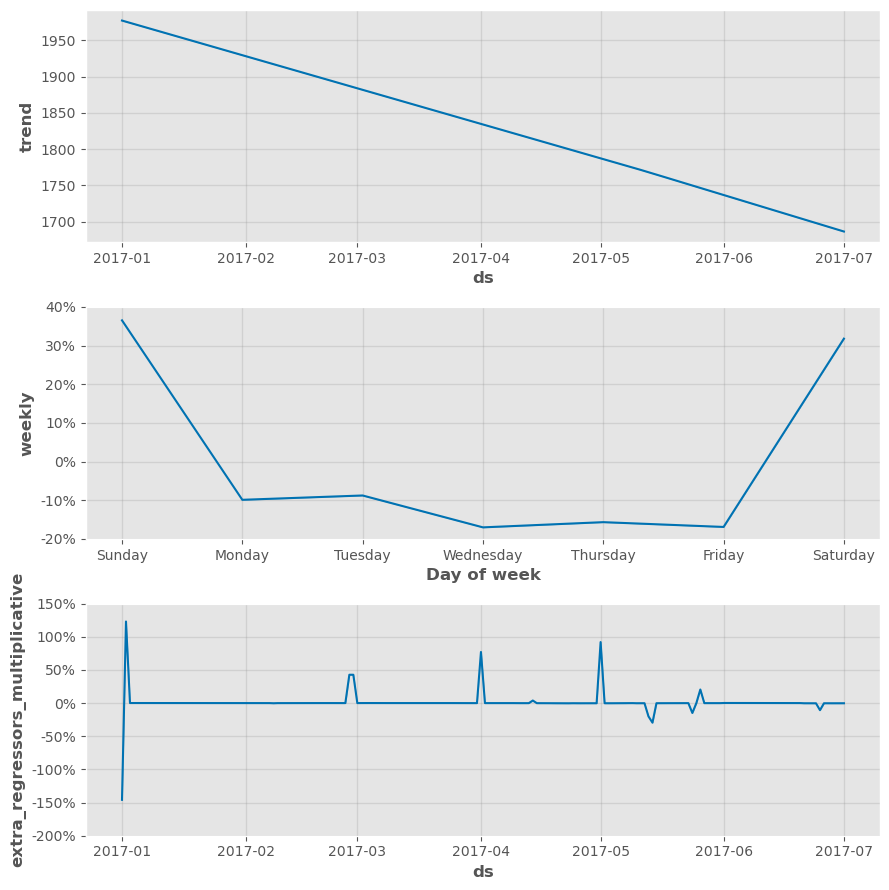

In [266]:
store_nbr = '9'
family_ = 'CLEANING'
X_train, X_valid, y_train, y_valid = get_time_series(store_nbr, family_, df_train, time_periods)
y_fit_forecast, y_valid_forecast = prophet_forecast_series(X_train, X_valid, y_train, y_valid, add_features)

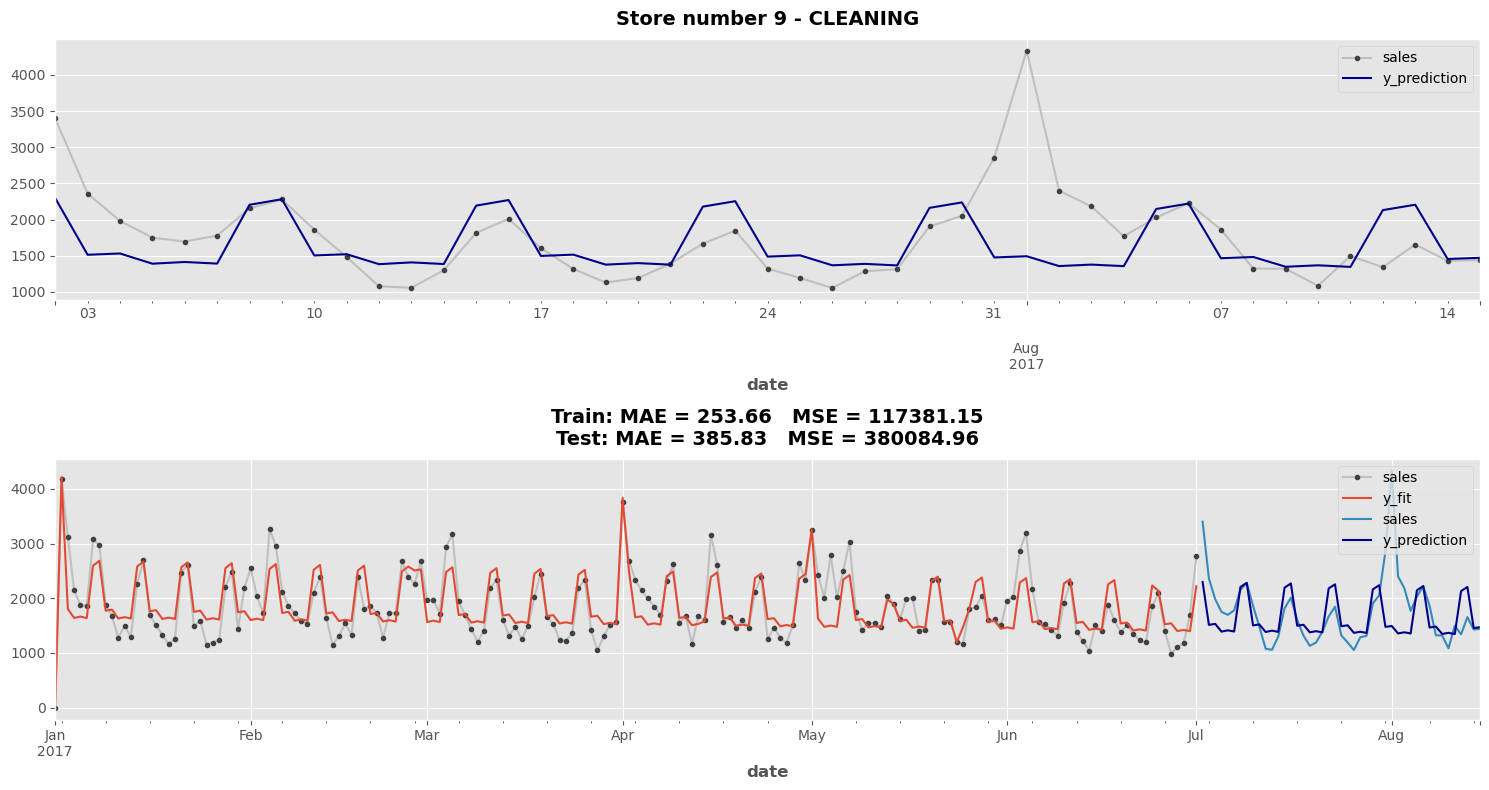

In [116]:
plot_timeseries(store_nbr, family_, y_train, y_fit_forecast, y_valid, y_valid_forecast)

Теперь прогнозируем каждый временной ряд и считаем RMSLE

In [117]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [249]:
store_nbr_set = list(set([df_test.index[i][0] for i in range(len(df_test.index))]))
store_nbr_set.sort()
print(len(store_nbr_set))

54


In [118]:
store_nbr_set = list(set([df_test.index[i][0] for i in range(len(df_test.index))]))
store_nbr_set.sort()
test_forecast_subm = pd.DataFrame()
RMSLE_train_dict = dict()
RMSLE_valid_dict = dict()
for store_nbr in tqdm(store_nbr_set):
    for family in family_set:
        X_train, X_valid, y_train, y_valid = get_time_series(store_nbr, family, df_train, time_periods)
        y_fit_forecast, y_valid_forecast = prophet_forecast_series(X_train, X_valid, y_train, y_valid, add_features)
        RMSLE_train_dict[(store_nbr, family)] = mean_squared_log_error(y_train, y_fit_forecast)
        RMSLE_valid_dict[(store_nbr, family)] = mean_squared_log_error(y_valid, y_valid_forecast)
        
RMSLE_train_values = np.array(list(RMSLE_train_dict.values()))
RMSLE_valid_values = np.array(list(RMSLE_valid_dict.values()))
RMSLE_train = np.sqrt(np.mean(RMSLE_train_values**2))
RMSLE_valid = np.sqrt(np.mean(RMSLE_valid_values**2))

100%|██████████| 54/54 [09:48<00:00, 10.89s/it]


In [124]:
print(RMSLE_train)
print(RMSLE_valid)

0.6988870453496774
0.570092441100131


In [37]:
store_nbr_set = list(set([df_test.index[i][0] for i in range(len(df_test.index))]))
store_nbr_set.sort()
test_forecast_subm = pd.DataFrame()

for store_nbr in tqdm(store_nbr_set):
    for family in family_set:
        X_train, X_valid, y_train, y_valid, X_test = get_time_series(store_nbr, family, df_train, time_periods, df_test_)
        test_forecast = pd.DataFrame(prophet_forecast_series(X_train, X_valid, y_train, y_valid, add_features, X_test))
        break
        test_forecast = test_forecast.rename(columns = {'yhat': 'sales'})
        test_forecast.index = test_forecast.index.to_period('D')
        temp_id = pd.DataFrame(df_test.loc[store_nbr, family]['id'])
        test_forecast = temp_id.merge(test_forecast, left_index=True, right_index=True)
        test_forecast['store_nbr'] = store_nbr
        test_forecast['family'] = family
        

        test_forecast_subm = pd.concat([test_forecast_subm, test_forecast], axis = 0)

TypeError: 'Period' object is not subscriptable

In [2026]:
test_forecast_subm = test_forecast_subm.reset_index()
test_forecast_subm = test_forecast_subm.set_index(['date', 'store_nbr', 'family']).sort_index()

In [236]:
test_forecast_subm

""


In [2029]:
test_forecast_subm.to_csv('Store_sales_submission.csv', index = False)